#Load the necessary Libraries

In [16]:
#Load the necessary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data cleanup
**Data cleanup is done in excel by reducing the rows and columns to avoid memory issue. But still there are some but can be manageable with Python libraries**
- **annual_inc** was having invalid number format like 6.00E+05(scientific format) etc changed to numeric format
- Many columns where filled with only NA those were removed from analaysis, created a new sheet
- collections_12_mths_ex_med
- mths_since_last_major_derog
- policy_code
- application_type
- annual_inc_joint
- dti_joint
- verification_status_joint
- acc_now_delinq
- tot_coll_amt
- tot_cur_bal
- open_acc_6m
- open_il_6m
- open_il_12m
- open_il_24m
- mths_since_rcnt_il
- total_bal_il
- il_util
- open_rv_12m
- open_rv_24m
- max_bal_bc
- all_util
- total_rev_hi_lim
- inq_fi
- total_cu_tl
- inq_last_12m
- acc_open_past_24mths
- avg_cur_bal
- bc_open_to_buy
- bc_util
- chargeoff_within_12_mths
- delinq_amnt
- mo_sin_old_il_acct
- mo_sin_old_rev_tl_op
- mo_sin_rcnt_rev_tl_op
- mo_sin_rcnt_tl
- mort_acc
- mths_since_recent_bc
- mths_since_recent_bc_dlq
- mths_since_recent_inq
- mths_since_recent_revol_delinq
- num_accts_ever_120_pd
- num_actv_bc_tl
- num_actv_rev_tl
- num_bc_sats
- num_bc_tl
- num_il_tl
- num_op_rev_tl
- num_rev_accts
- num_rev_tl_bal_gt_0
- num_sats
- num_tl_120dpd_2m
- num_tl_30dpd
- num_tl_90g_dpd_24m
- num_tl_op_past_12m
- pct_tl_nvr_dlq
- percent_bc_gt_75
- pub_rec_bankruptcies
- tax_liens
- tot_hi_cred_lim
- total_bal_ex_mort
- total_bc_limit
- total_il_high_credit_limit

3. **Funded_Amount** is having decimal values which are outliers
4. **Int_rate** is having % symbol at the end
5. **term** is having months , months can be removed
6. **pymnt_plan** can be removed as it only value 'n'
7. **initial_list_status** can be removed
8. **home_ownership** has NONE as 3 rows this can be removed , outlier

In [17]:
#Load the dataset
loandf = pd.read_csv('refined_loan.csv', low_memory=False) 

In [18]:
def custom_date_parser(date_string):
    month, year = date_string.split('-')
    year = int(year)
    # 1946 is the starting year dated in excel 
    if year >= 0 and year <= 24:  
        year += 2000
    else:
        year += 1900
    return pd.to_datetime(f"{month}-{year}", format='%b-%Y')

In [45]:
def normalize_emp_length(emp_length):
    if emp_length == '10+ years':
        return 10
    elif emp_length == '< 1 year':
        return 0
    else:
        # Extract the number of years (assuming it's in the form 'X years' or 'X year')
        return int(emp_length.split()[0])

In [19]:
loandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       39717 non-null  int64  
 1   member_id                39717 non-null  int64  
 2   loan_amnt                39717 non-null  int64  
 3   funded_amnt              39717 non-null  int64  
 4   funded_amnt_inv          39717 non-null  float64
 5   term                     39717 non-null  object 
 6   int_rate                 39717 non-null  object 
 7   installment              39717 non-null  float64
 8   grade                    39717 non-null  object 
 9   sub_grade                39717 non-null  object 
 10  emp_title                37258 non-null  object 
 11  emp_length               38642 non-null  object 
 12  home_ownership           39717 non-null  object 
 13  annual_inc               39717 non-null  float64
 14  verification_status   

In [20]:
loandf['next_pymnt_d'] = loandf['next_pymnt_d'].fillna(0)
loandf['next_pymnt_d'] = pd.to_datetime(loandf['next_pymnt_d'], format='%b-%y', errors='coerce')
loandf['next_pymnt_year'] = loandf['next_pymnt_d'].dt.year


loandf['earliest_cr_line'] = loandf['earliest_cr_line'].apply(custom_date_parser)
loandf['earliest_cr_line_year'] = loandf['earliest_cr_line'].dt.year


loandf['issue_date'] = loandf['issue_d'].apply(custom_date_parser)
loandf['issue_date_year'] = loandf['issue_date'].dt.year
print(loandf['issue_date'].head())


0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
4   2011-12-01
Name: issue_date, dtype: datetime64[ns]


In [21]:
loandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       39717 non-null  int64         
 1   member_id                39717 non-null  int64         
 2   loan_amnt                39717 non-null  int64         
 3   funded_amnt              39717 non-null  int64         
 4   funded_amnt_inv          39717 non-null  float64       
 5   term                     39717 non-null  object        
 6   int_rate                 39717 non-null  object        
 7   installment              39717 non-null  float64       
 8   grade                    39717 non-null  object        
 9   sub_grade                39717 non-null  object        
 10  emp_title                37258 non-null  object        
 11  emp_length               38642 non-null  object        
 12  home_ownership           39717 n

In [22]:
# remove % at the end
loandf['int_rate']= loandf['int_rate'].apply(lambda x: float(x[:-1]) if x[-1]=="%" else float(x))
loandf = loandf.dropna(subset=['revol_util'])
loandf['revol_util']= loandf['revol_util'].apply(lambda x: float(x[:-1]) if x[-1]=="%" else float(x))

In [23]:
# remove 'months' at the end
loandf['term']= loandf['term'].apply(lambda x: int(x.split()[0]))

In [24]:
df = loandf.dropna()

## Univariate analysis

Text(0.5, 1.0, 'Payment Status Type')

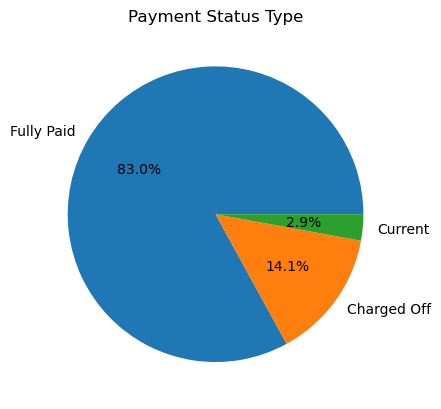

In [25]:
##  Loan status
loanstat = loandf['loan_status'].value_counts()
plt.pie(loanstat, labels=loanstat.index, autopct='%1.1f%%')
plt.title("Payment Status Type")

1. Based on the current status fully paid percentage is more
2. Charged off / Defaulters are 14.1 percent need to check the loan amount for these people
3. Current also needs to be checked how these cutomers are paying back based on DTI

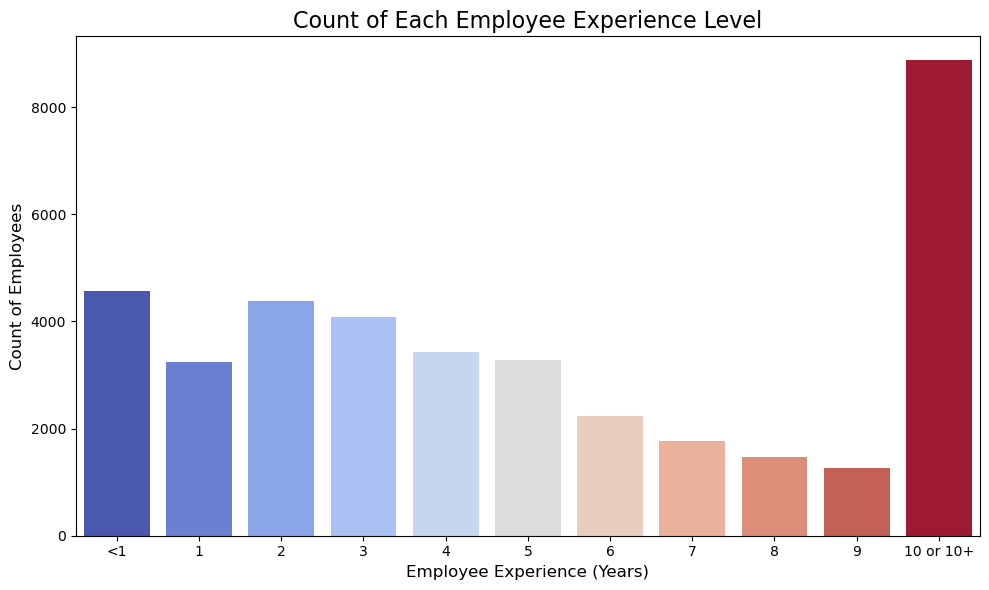

In [76]:
loandf = loandf.dropna(subset=['emp_length'])
loandf['emp_length_normalized'] = loandf['emp_length'].apply(normalize_emp_length)

# Group by the normalized 'emp_length' to count the number of occurrences of each experience level
experience_counts = loandf['emp_length_normalized'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=experience_counts.index, y=experience_counts.values, hue=experience_counts.index, palette='coolwarm', legend=False)

# Add labels and title
plt.title('Count of Each Employee Experience Level', fontsize=16)
x_labels = experience_counts.index.tolist()  # Get the original labels
x_labels = ['<1' if x == 0 else '10 or 10+' if x == 10 else str(x) for x in x_labels]  # Modify the labels for 0 and 10
plt.xticks(ticks=range(len(x_labels)), labels=x_labels) 
plt.xlabel('Employee Experience (Years)', fontsize=12)
plt.ylabel('Count of Employees', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_29051/2152253837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulters['emp_length_normalized'] = defaulters['emp_length'].apply(normalize_emp_length)


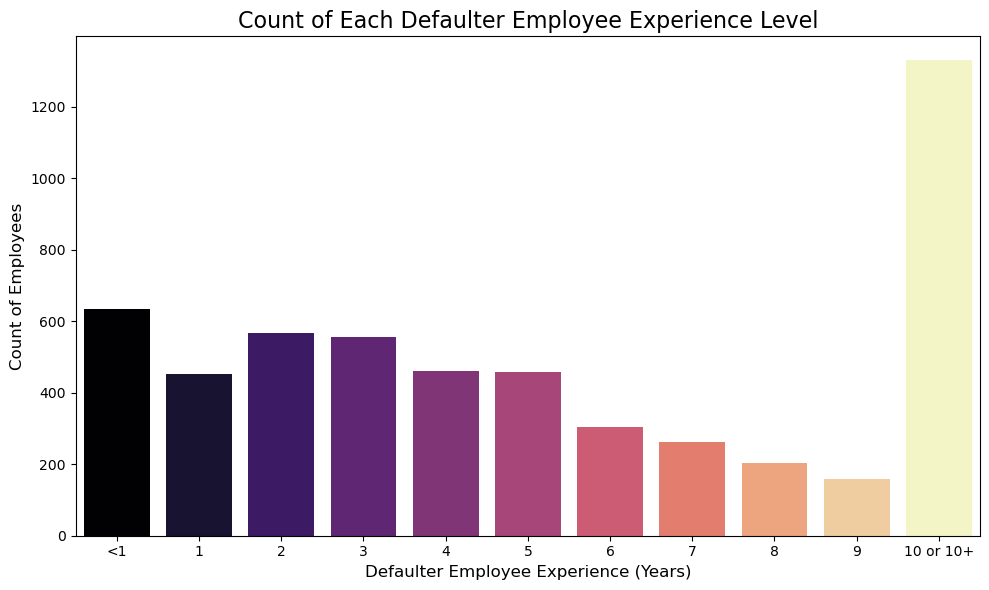

In [78]:
loandf = loandf.dropna(subset=['emp_length'])
defaulters = loandf[loandf['loan_status'] == 'Charged Off']
defaulters['emp_length_normalized'] = defaulters['emp_length'].apply(normalize_emp_length)

# Group by the normalized 'emp_length' to count the number of occurrences of each experience level
experience_counts = defaulters['emp_length_normalized'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(x=experience_counts.index, y=experience_counts.values, hue=experience_counts.index, palette='magma', legend=False)

# Add labels and title
plt.title('Count of Each Defaulter Employee Experience Level', fontsize=16)
x_labels = experience_counts.index.tolist()  # Get the original labels
x_labels = ['<1' if x == 0 else '10 or 10+' if x == 10 else str(x) for x in x_labels]  # Modify the labels for 0 and 10
plt.xticks(ticks=range(len(x_labels)), labels=x_labels) 
plt.xlabel('Defaulter Employee Experience (Years)', fontsize=12)
plt.ylabel('Count of Employees', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

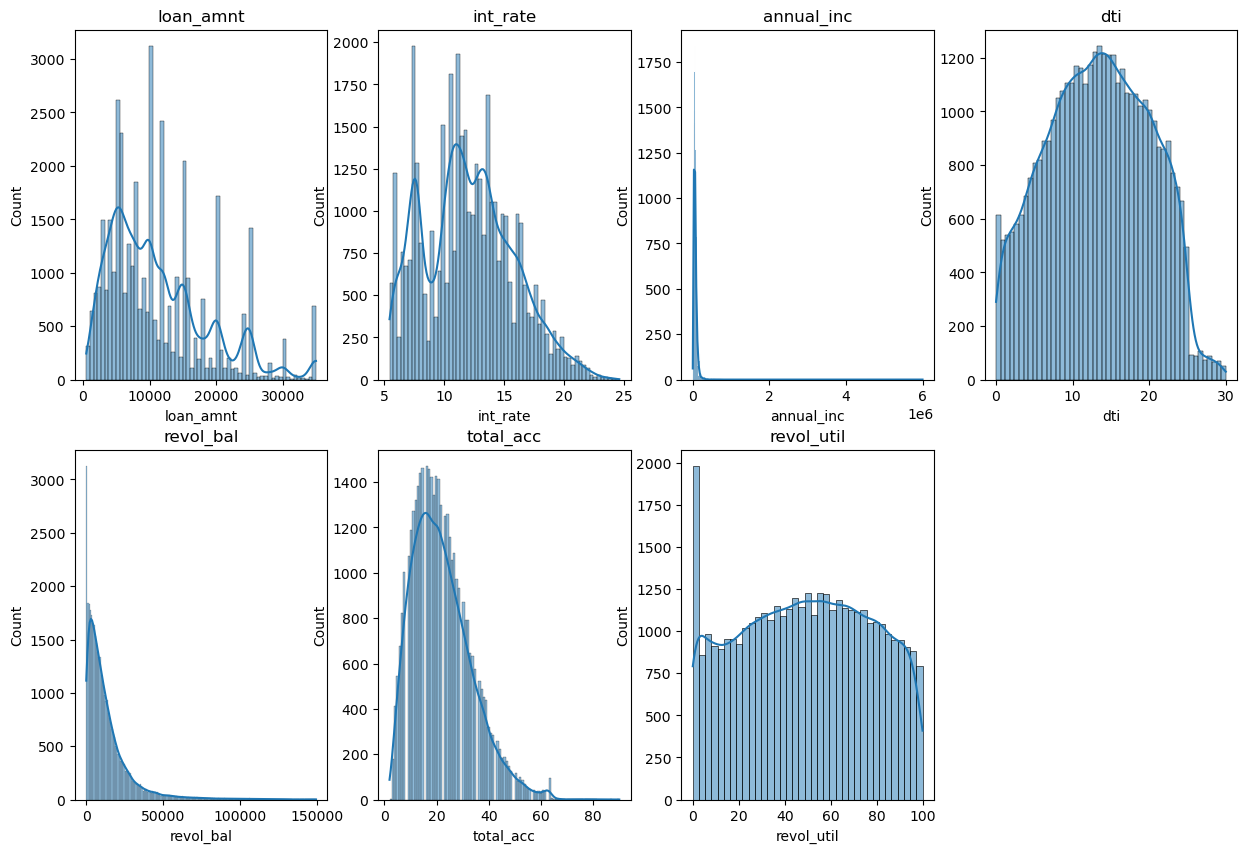

In [26]:
## Cateogry Type status

numerical_columns = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_bal', 'total_acc', 'revol_util']

# Plot histograms for each numerical column
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(loandf[column].dropna(), kde=True)
    plt.title(column)

plt.show()

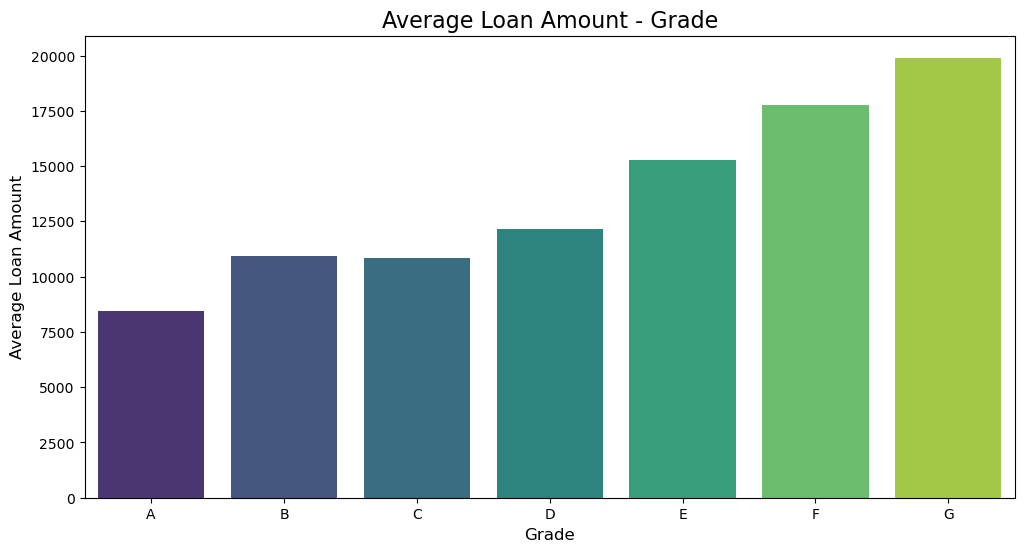

In [80]:
grade_average = loandf.groupby('grade')['funded_amnt'].mean().reset_index()


# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='grade', y='funded_amnt', data=grade_average, hue='grade', palette='viridis', legend=False)

# Add labels and title
plt.title('Average Loan Amount - Grade', fontsize=16)
plt.xlabel('Grade', fontsize=12)
plt.ylabel('Average Loan Amount', fontsize=12)

# Show plot

plt.show()

  grade  count
0     A   9695
1     B  11685
2     C   7914
3     D   5179
4     E   2784
5     F   1025
6     G    313


/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_29051/565042806.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='grade', y='count', data=grade_counts, palette='Spectral')


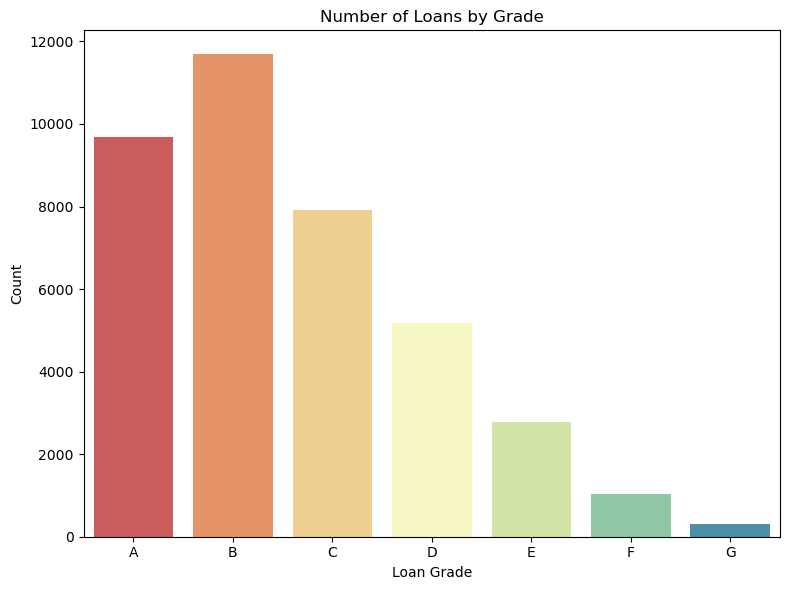

In [81]:
grade_counts = loandf.groupby('grade').size().reset_index(name='count')

# Display the result
print(grade_counts)

# Create bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='grade', y='count', data=grade_counts, palette='Spectral')

# Add labels and title
plt.title('Number of Loans by Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Count')

# Show plot
plt.tight_layout()
plt.show()

## Derived Metrics

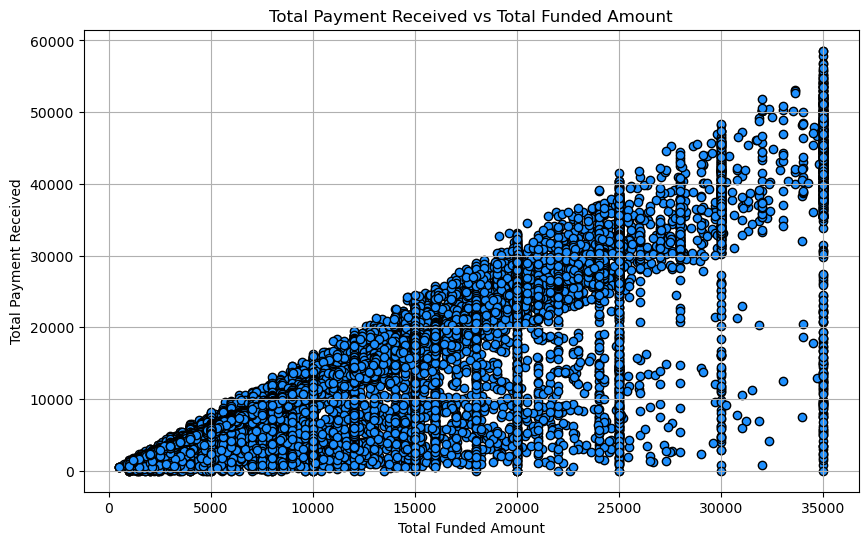

In [27]:
loandf['total_payment_with_interest'] = loandf['total_rec_prncp'] + loandf['total_rec_int']
plt.figure(figsize=(10, 6))
plt.scatter(loandf['funded_amnt'], loandf['total_payment_with_interest'], color='dodgerblue', edgecolor='black')
plt.title('Total Payment Received vs Total Funded Amount')
plt.xlabel('Total Funded Amount')
plt.ylabel('Total Payment Received')
plt.grid(True)
plt.show()

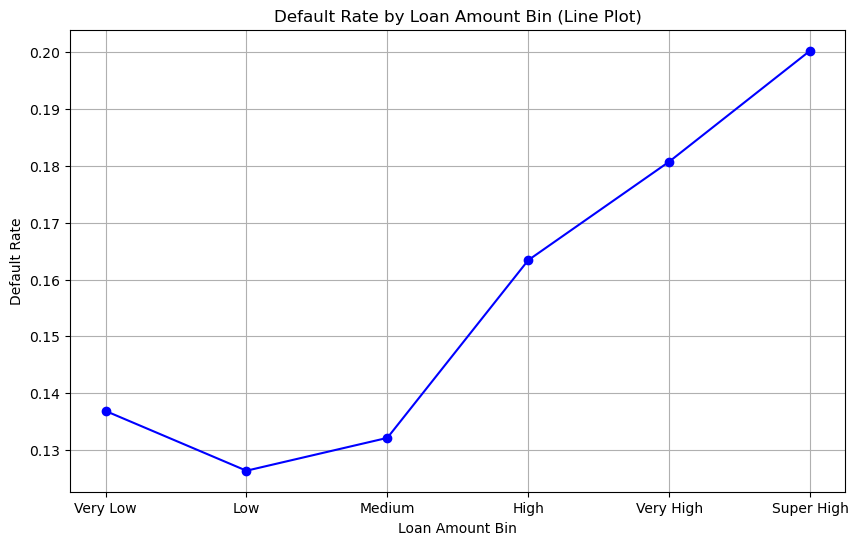

In [29]:
# Ensure 'loan_status' is correctly identifying 'Charged Off' loans
charged_off =loandf[loandf['loan_status'] == 'Charged Off']

# Create bins for loan amounts
bins = [0, 5000, 10000, 15000, 20000, 25000, 35000]  # Loan amount categories bins/buckets
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Super High']
loandf['loan_amnt_bin'] = pd.cut(loandf['loan_amnt'], bins=bins, labels=labels, include_lowest=True)

# Calculate default rate for each loan amount bin
loan_amnt_default_rate = charged_off['loan_amnt_bin'].value_counts() / loandf['loan_amnt_bin'].value_counts()

plt.figure(figsize=(10, 6))
loan_amnt_default_rate.sort_index().plot(kind='line', marker='o', color='blue')
plt.title('Default Rate by Loan Amount Bin (Line Plot)')
plt.xlabel('Loan Amount Bin')
plt.ylabel('Default Rate')
plt.grid(True)
plt.show()


<Axes: >

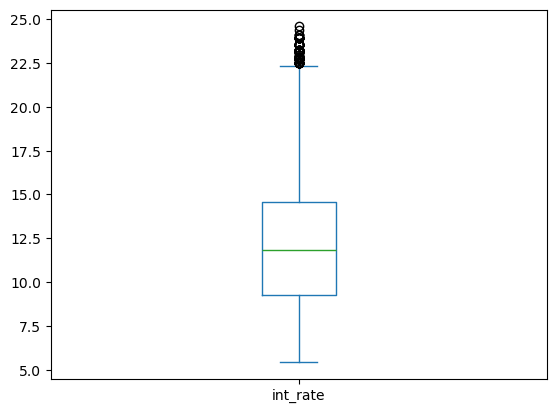

In [33]:

loandf['int_rate'].plot.box()

In [34]:
loandf['int_rate'].describe()

count    39667.000000
mean        12.016587
std          3.723856
min          5.420000
25%          9.250000
50%         11.830000
75%         14.540000
max         24.590000
Name: int_rate, dtype: float64

/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/2269204423.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_amnt_bin', y='int_rate', data=loandf, palette='coolwarm')


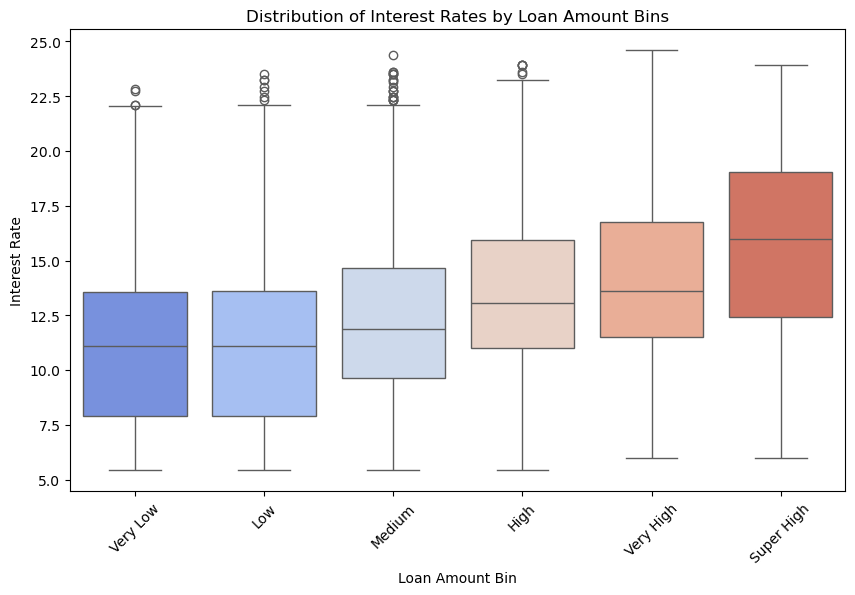

In [165]:
# Define loan amount bins
loan_amnt_bins = [0, 5000, 10000, 15000, 20000, 25000, 35000]
loan_amnt_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Super High']

# Create a new column for loan amount bins
loandf['loan_amnt_bin'] = pd.cut(loandf['loan_amnt'], bins=loan_amnt_bins, labels=loan_amnt_labels, include_lowest=True)

# Box plot for interest rate distribution across loan amount bins
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_amnt_bin', y='int_rate', data=loandf, palette='coolwarm')
plt.title('Distribution of Interest Rates by Loan Amount Bins')
plt.xlabel('Loan Amount Bin')
plt.ylabel('Interest Rate')
plt.xticks(rotation=45)
plt.show()


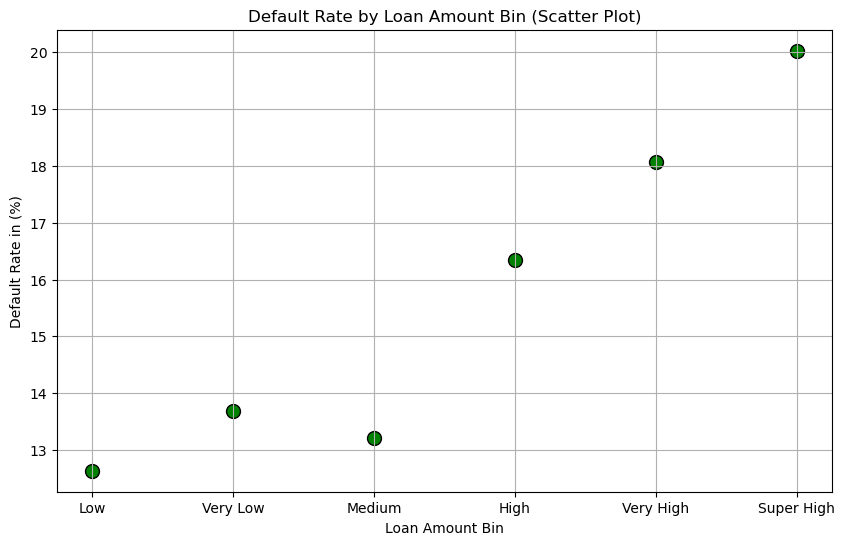

In [170]:
# Same loan amount binning and default rate calculation as above

# Plotting the default rate for each loan amount bin (Scatter plot)
plt.figure(figsize=(10, 6))
plt.scatter(loan_amnt_default_rate.index, loan_amnt_default_rate*100, color='green', s=100, edgecolor='black')
plt.title('Default Rate by Loan Amount Bin (Scatter Plot)')
plt.xlabel('Loan Amount Bin')
plt.ylabel('Default Rate in (%)')
plt.grid(True)
plt.show()


Larger Loans = Higher Risk: The upward trend in both graphs supports the hypothesis that larger loans have a higher risk of default. Lenders may need to implement stricter criteria or higher interest rates for larger loans to mitigate risk.

Smaller Loans = Lower Risk: Smaller loans appear to be less risky, with consistently lower default rates.

/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/1474992822.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  repayment_status_pivot = filtered_data.pivot_table(index='earliest_cr_line_year',


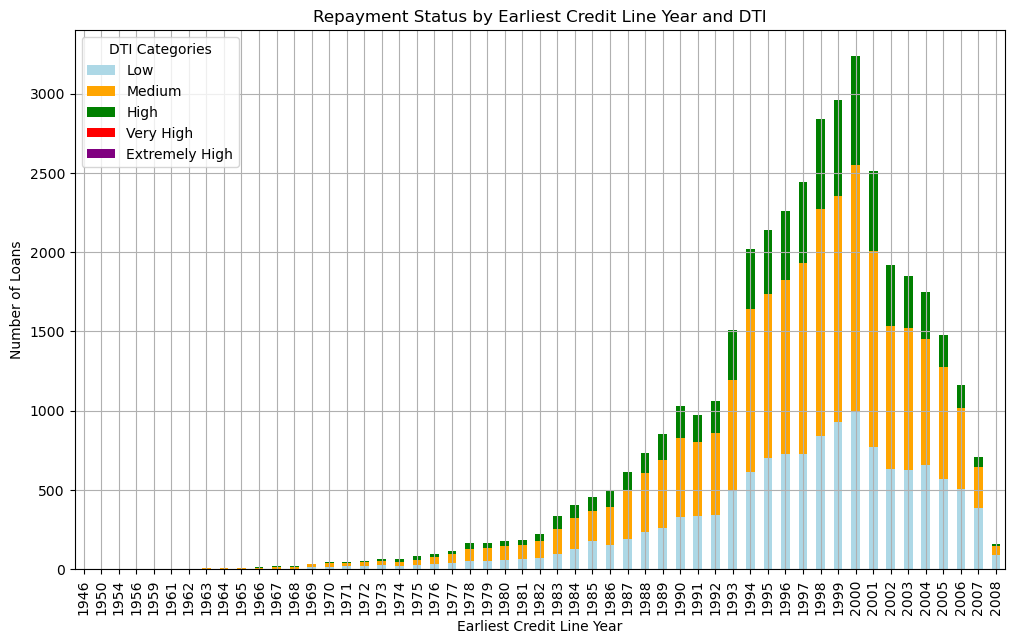

In [256]:
# Assuming 'loan_status', 'earliest_cr_line', and 'dti' columns are cleaned
# Create a filtered dataframe with non-null values for loan_status, earliest_cr_line, and dti
filtered_data = loandf.dropna(subset=['loan_status', 'earliest_cr_line', 'dti'])

# Since earliest_cr_line is already a datetime, extract the year
filtered_data['earliest_cr_line_year'] = filtered_data['earliest_cr_line'].dt.year

# Bin DTI into categories (Low, Medium, High, etc.)
dti_bins = [0, 10, 20, 30, 40, 50]  # Define DTI bins
dti_labels = ['Low', 'Medium', 'High', 'Very High', 'Extremely High']
filtered_data['dti_bin'] = pd.cut(filtered_data['dti'], bins=dti_bins, labels=dti_labels)

# Create a pivot table to calculate counts of loan status for each combination of year and dti_bin
repayment_status_pivot = filtered_data.pivot_table(index='earliest_cr_line_year', 
                                                   columns='dti_bin', 
                                                   values='loan_status', 
                                                   aggfunc='count')

# Plot a stacked bar chart of repayment status by earliest credit line year and DTI
repayment_status_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), color=['lightblue', 'orange', 'green', 'red', 'purple'])
plt.title('Repayment Status by Earliest Credit Line Year and DTI')
plt.xlabel('Earliest Credit Line Year')
plt.ylabel('Number of Loans')
plt.legend(title='DTI Categories')
plt.grid(True)
plt.show()


### considered dti, earliest credit line to find out if dti and earliest_cr_line but didnt help much

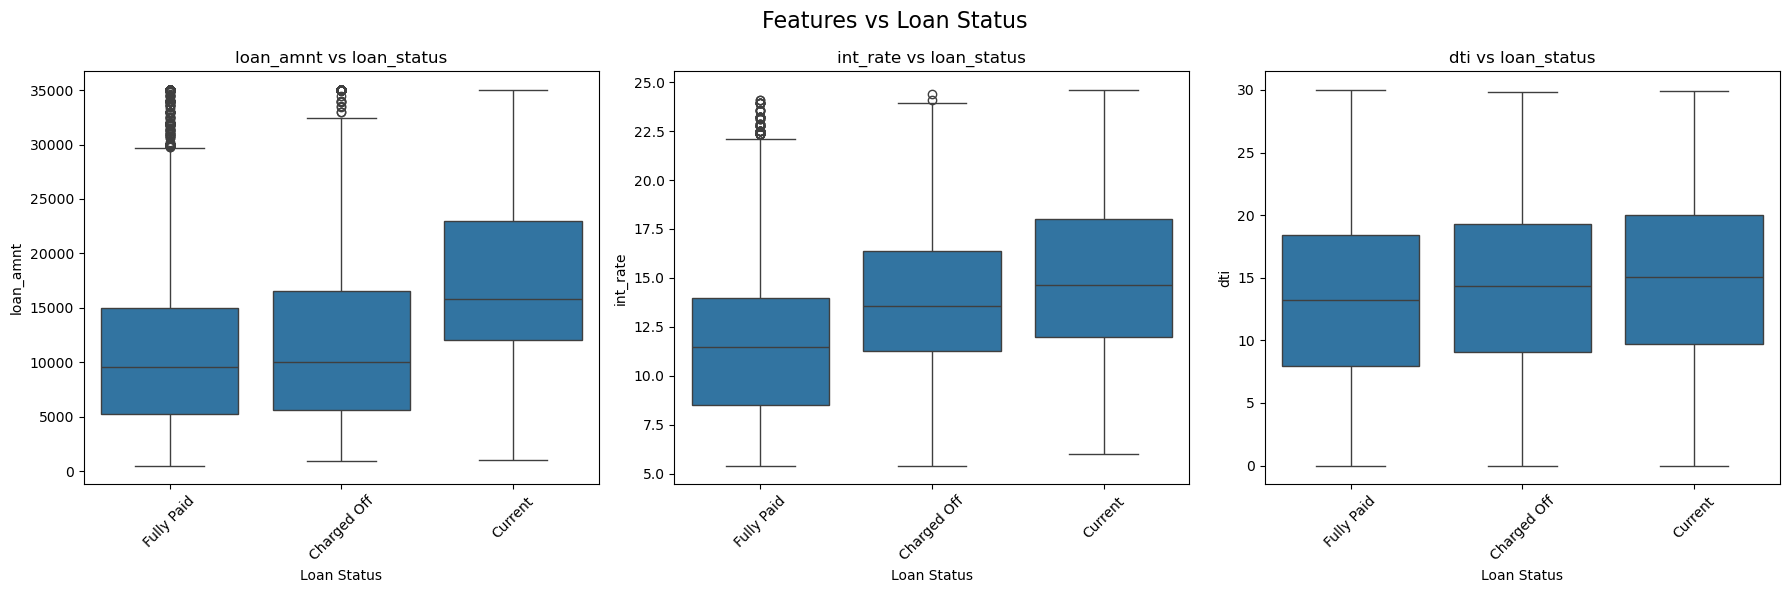

In [35]:
features = ['loan_amnt', 'int_rate', 'dti']
target = 'loan_status'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Features vs Loan Status', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature against the target variable
for i, feature in enumerate(features):
    sns.boxplot(x=target, y=feature, data=loandf, ax=axes[i])
    axes[i].set_title(f'{feature} vs {target}')
    axes[i].set_xlabel('Loan Status')
    axes[i].set_ylabel(feature)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

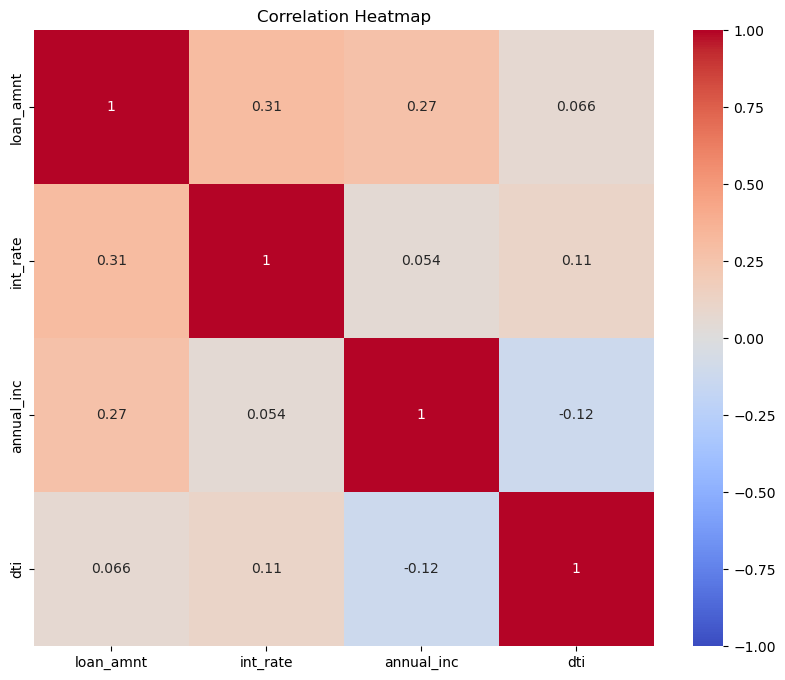

In [148]:
correlation_matrix = loandf[features].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

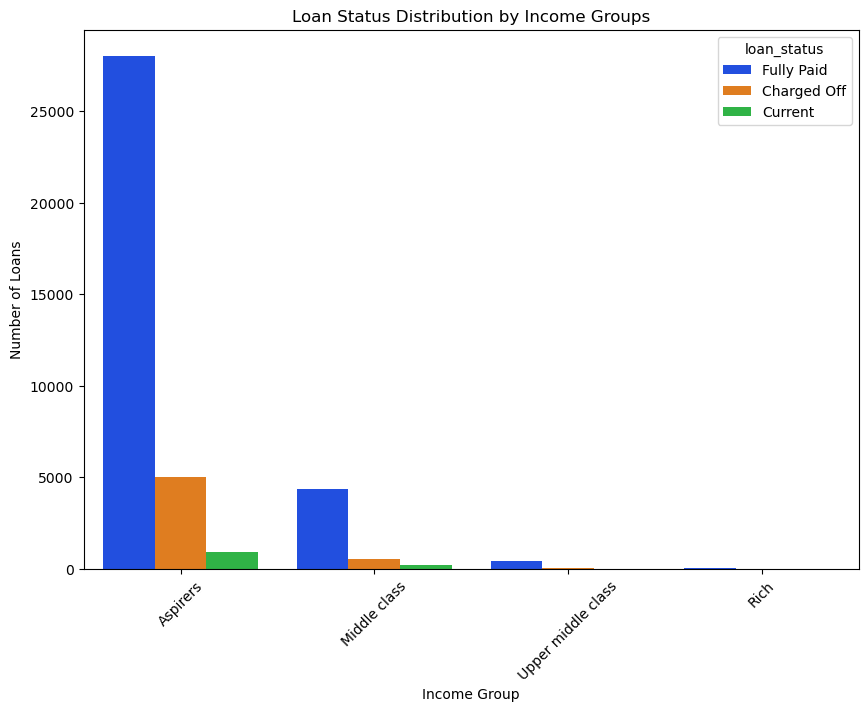

In [36]:
income_bins = [0, 100000, 200000, 500000, loandf['annual_inc'].max()]
income_labels = ['Aspirers', 'Middle class', 'Upper middle class', 'Rich']

# Create a new column for income bins
loandf['income_bin'] = pd.cut(loandf['annual_inc'], bins=income_bins, labels=income_labels, include_lowest=True)

# Plot loan status by income bin
plt.figure(figsize=[10,7])
sns.countplot(x='income_bin', hue='loan_status', data=loandf, palette='bright')
plt.title('Loan Status Distribution by Income Groups')
plt.xlabel('Income Group')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.show()

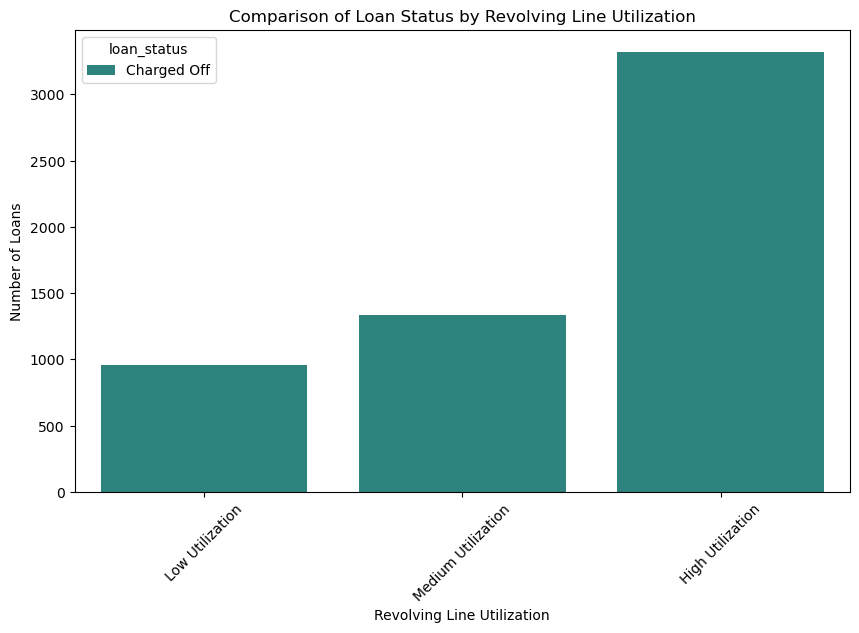

In [44]:
# Create bins for 'revol_util'
revol_bins = [0, 25, 50, 100]  # Revolving utilization rate categories
revol_labels = ['Low Utilization', 'Medium Utilization', 'High Utilization']
defaulters = loandf[loandf['loan_status'] == 'Charged Off']
# Create a new column for revolving utilization bins
loandf['revol_util_bin'] = pd.cut(loandf['revol_util'], bins=revol_bins, labels=revol_labels, include_lowest=True)

# Create a countplot for loan_status and revol_util_bin
plt.figure(figsize=(10, 6))
sns.countplot(x='revol_util_bin', hue='loan_status', data=defaulters, palette='rocket')
plt.title('Comparison of Loan Status by Revolving Line Utilization')
plt.xlabel('Revolving Line Utilization')
plt.ylabel('Number of Loans')

plt.xticks(rotation=45)
plt.show()

The purpose with the maximum number of defaulters is 'debt_consolidation' with 2762 defaulters.


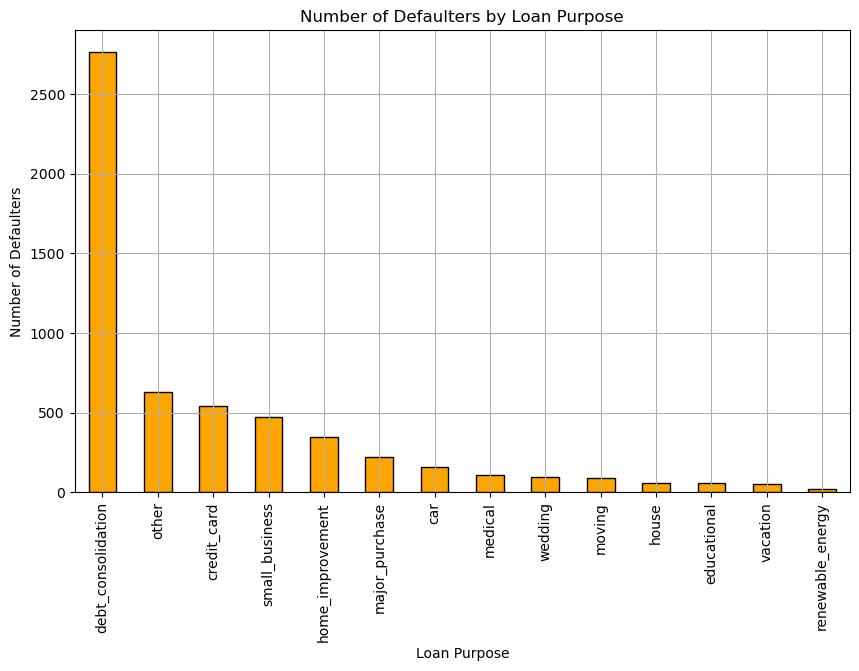

In [190]:
# Filter the dataset for defaulters (loan_status == 'Charged Off')
defaulters = loandf[loandf['loan_status'] == 'Charged Off']

# Group by 'purpose' and count the number of defaulters in each group
defaulters_by_purpose = defaulters['purpose'].value_counts()

# Display the group with the maximum number of defaulters
max_defaulters_purpose = defaulters_by_purpose.idxmax()  # Purpose with the most defaulters
max_defaulters_count = defaulters_by_purpose.max()  # Number of defaulters in that purpose group

# Output the results
print(f"The purpose with the maximum number of defaulters is '{max_defaulters_purpose}' with {max_defaulters_count} defaulters.")

# Plotting the defaulters by purpose for better visualization
plt.figure(figsize=(10, 6))
defaulters_by_purpose.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Number of Defaulters by Loan Purpose')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Defaulters')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


## segmented variant analysis

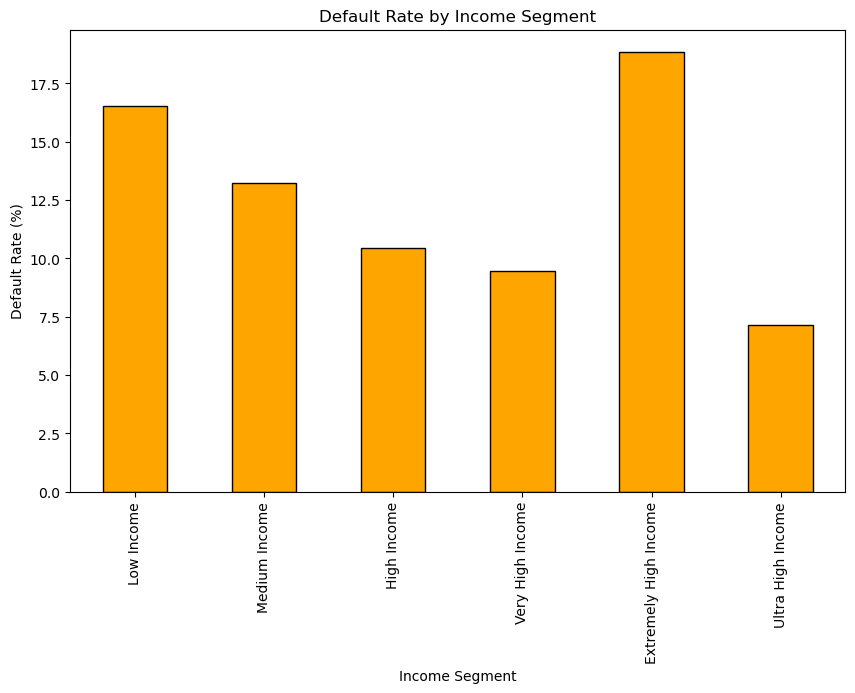

In [191]:
# Create income segments
income_bins = [0, 50000, 100000, 200000, 500000, 1000000, loandf['annual_inc'].max()]
income_labels = ['Low Income', 'Medium Income', 'High Income', 'Very High Income', 'Extremely High Income', 'Ultra High Income']
loandf['income_segment'] = pd.cut(loandf['annual_inc'], bins=income_bins, labels=income_labels, include_lowest=True)

# Filter defaulters (loan_status == 'Charged Off')
charged_off = loandf[loandf['loan_status'] == 'Charged Off']

# Calculate default rate for each income segment
default_rate_by_income = (charged_off['income_segment'].value_counts() / loandf['income_segment'].value_counts())*100

# Plot the default rate by income segment
plt.figure(figsize=(10, 6))
default_rate_by_income.sort_index().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Default Rate by Income Segment')
plt.xlabel('Income Segment')
plt.ylabel('Default Rate (%)')
plt.show()


In [176]:
purpose_by_int_rate = loandf.groupby(['purpose', 'int_rate_segment']).size().unstack()
print(purpose_by_int_rate)

int_rate_segment    Very Low  Low  Medium  High
purpose                                        
car                        0    0       0     0
credit_card                0    0       0     0
debt_consolidation         0    0       0     0
educational                0    0       0     0
home_improvement           0    0       0     0
house                      0    0       0     0
major_purchase             0    0       0     0
medical                    0    0       0     0
moving                     0    0       0     0
other                      0    0       0     0
renewable_energy           0    0       0     0
small_business             0    0       0     0
vacation                   0    0       0     0
wedding                    0    0       0     0


/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/803401176.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purpose_by_int_rate = loandf.groupby(['purpose', 'int_rate_segment']).size().unstack()


/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/3907367459.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purpose_by_int_rate = loandf.groupby(['purpose', 'int_rate_segment']).size().unstack().fillna(0)


<Figure size 1200x800 with 0 Axes>

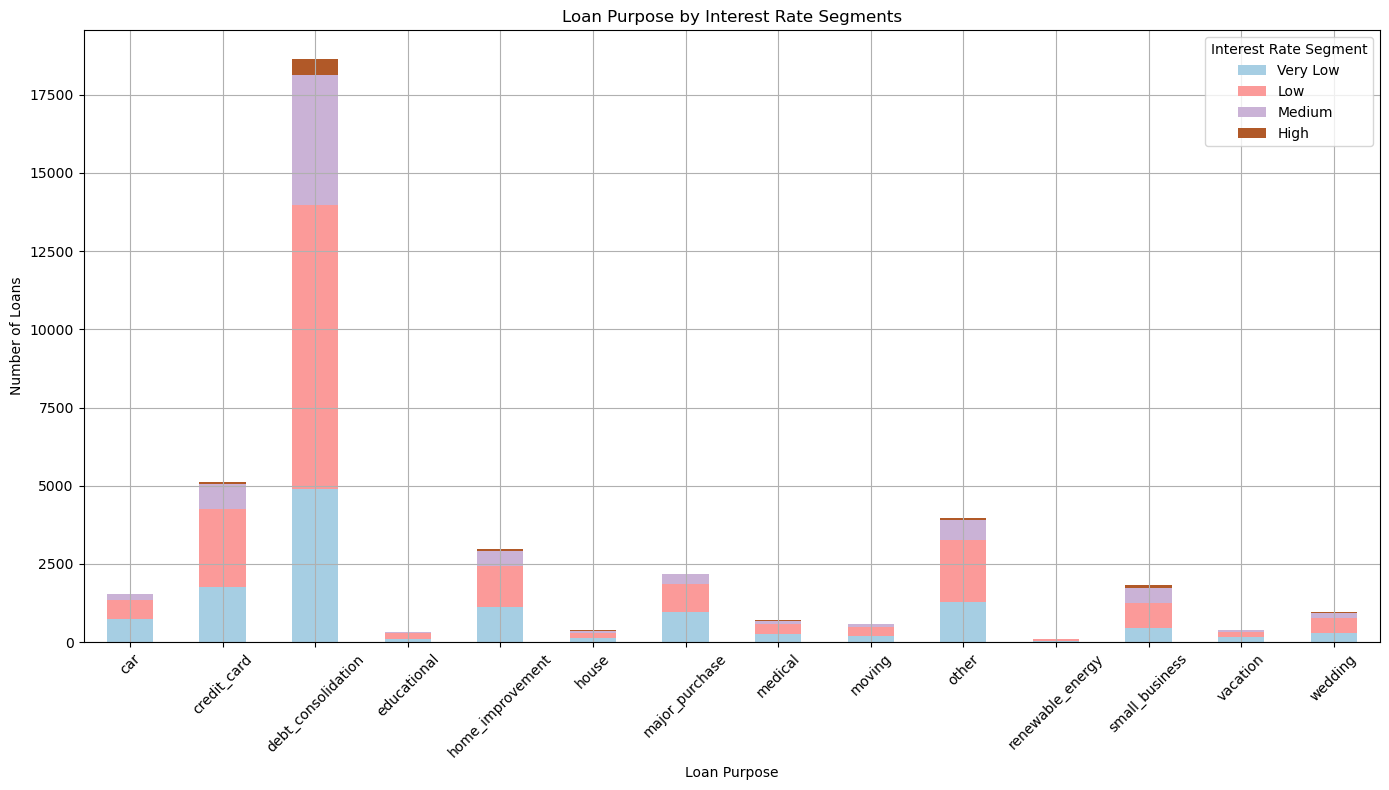

In [177]:
# Create interest rate segments
int_rate_bins = [0, 10, 15, 20, 25]  # Interest rate categories
int_rate_labels = ['Very Low', 'Low', 'Medium', 'High']
loandf['int_rate_segment'] = pd.cut(loandf['int_rate'], bins=int_rate_bins, labels=int_rate_labels, include_lowest=True)

# Group by loan purpose and interest rate segment
purpose_by_int_rate = loandf.groupby(['purpose', 'int_rate_segment']).size().unstack().fillna(0)

# Plot the data
plt.figure(figsize=(12, 8))
purpose_by_int_rate.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Paired')
plt.title('Loan Purpose by Interest Rate Segments')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Interest Rate Segment')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
int_rate_bins = [0, 10, 15, 20, 25]  # Interest rate categories
int_rate_labels = ['Very Low', 'Low', 'Medium', 'High']
loandf['int_rate_segment'] = pd.cut(loandf['int_rate'], bins=int_rate_bins, labels=int_rate_labels, include_lowest=True)

# Group by loan purpose and interest rate segment
purpose_by_int_rate = loandf.groupby(['purpose', 'int_rate_segment']).size().unstack().fillna(0)

# Plot the data
plt.figure(figsize=(12, 8))
purpose_by_int_rate.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='Paired')
plt.title('Loan Purpose by Interest Rate Segments')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Interest Rate Segment')
plt.grid(True)
plt.tight_layout()
plt.show()

Defaulters with 'Not Verified' are 2135 in number.


/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/3346724401.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=verification_status_counts.index, y=verification_status_counts.values, palette='Blues_d')


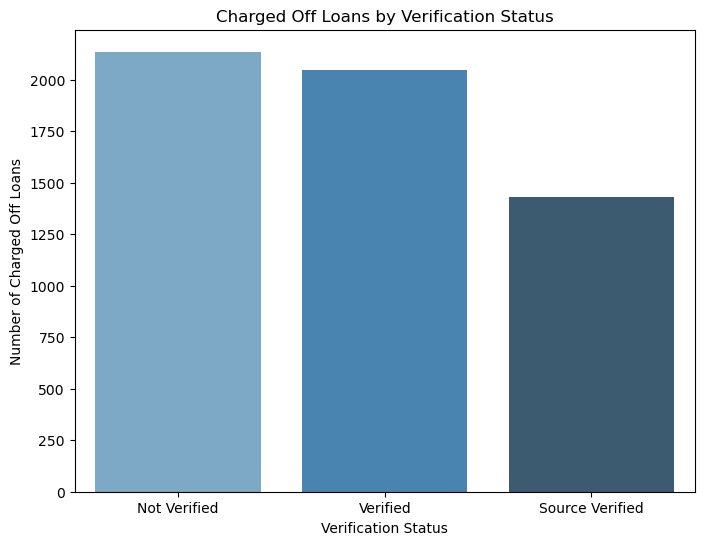

In [302]:
# Filter for loans with status "Charged Off"
charged_off = loandf[loandf['loan_status'] == 'Charged Off']

# Count the number of charged off loans for each verification status
verification_status_counts = charged_off['verification_status'].value_counts()
not_verified_count = verification_status_counts['Not Verified']


# Output the results
print(f"Defaulters with 'Not Verified' are {not_verified_count} in number.")

# Plot the count of charged off loans by verification status
plt.figure(figsize=(8, 6))
sns.barplot(x=verification_status_counts.index, y=verification_status_counts.values, palette='Blues_d')
plt.title('Charged Off Loans by Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Number of Charged Off Loans')
plt.show()

#### As Verified and Source Verified are same combining them both

{'Verified': 3342, 'Not Verified': 2042}
Defaulters with 'Not Verified' are 2042 in number.


/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_29051/1708362071.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_status_series.index, y=total_status_series.values, palette='Blues_d')


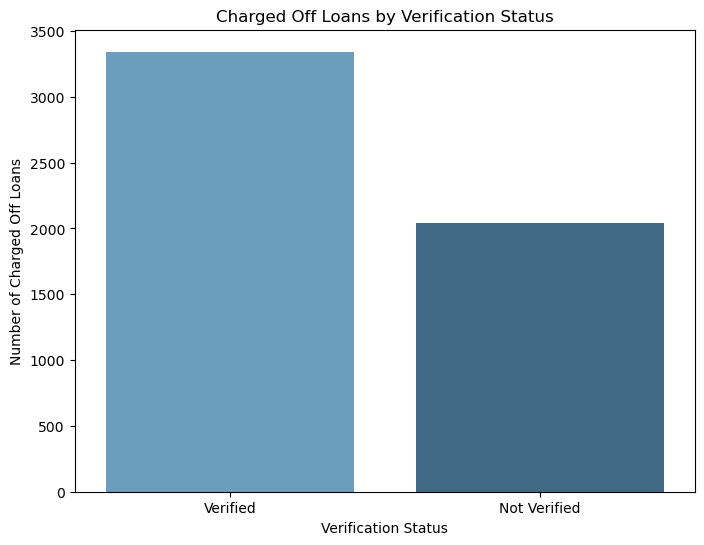

In [79]:

charged_off = loandf[loandf['loan_status'] == 'Charged Off']

# Count the number of charged off loans for each verification status
verification_status_counts = charged_off['verification_status'].value_counts()
not_verified_count = verification_status_counts['Not Verified']

total_status = {}
total_status['Verified'] = verification_status_counts['Verified'] + verification_status_counts['Source Verified']
total_status['Not Verified'] = not_verified_count
print(total_status)

# Output the results
print(f"Defaulters with 'Not Verified' are {not_verified_count} in number.")
total_status_series = pd.Series(total_status)
# Plot the count of charged off loans by verification status
plt.figure(figsize=(8, 6))
sns.barplot(x=total_status_series.index, y=total_status_series.values, palette='Blues_d')
plt.title('Charged Off Loans by Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Number of Charged Off Loans')
plt.show()

/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/1660966144.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=purpose_counts.index, y=purpose_counts.values, palette='Oranges_d')


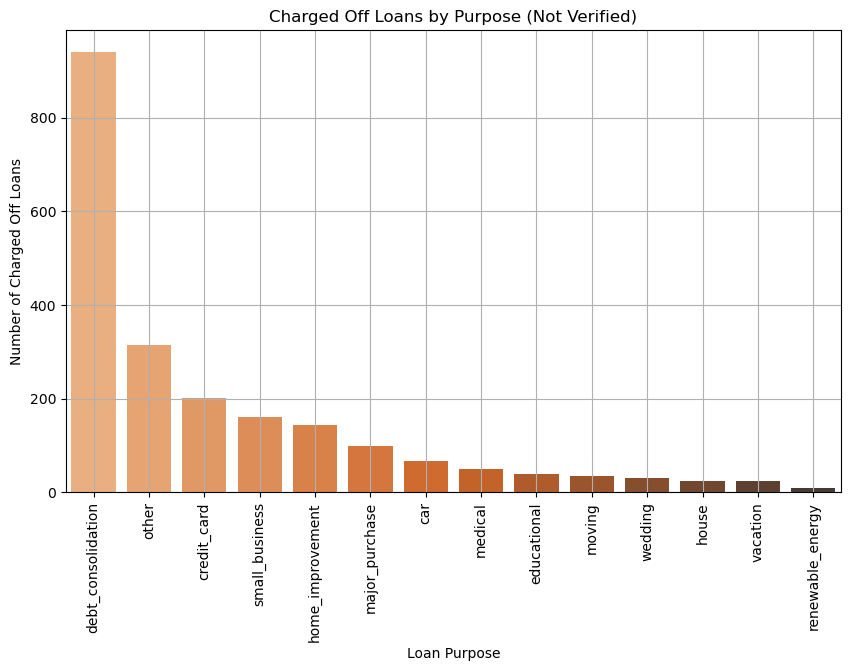

In [189]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for loans with status "Charged Off" and verification_status "Not Verified"
not_verified_charged_off = loandf[(loandf['loan_status'] == 'Charged Off') & 
                                  (loandf['verification_status'] == 'Not Verified')]

# Count the number of charged off loans by loan purpose
purpose_counts = not_verified_charged_off['purpose'].value_counts()

# Plot the number of charged off loans by purpose for 'Not Verified' loans
plt.figure(figsize=(10, 6))
sns.barplot(x=purpose_counts.index, y=purpose_counts.values, palette='Oranges_d')
plt.title('Charged Off Loans by Purpose (Not Verified)')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Charged Off Loans')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()


In [185]:
loan_status_counts = loandf.groupby(['member_id', 'loan_status']).size().unstack(fill_value=0)
loan_status_counts['total_loans'] = loan_status_counts.sum(axis=1)
members_with_multiple_loans = loan_status_counts[(loan_status_counts > 1).any(axis=1)]

# Display the result
print(members_with_multiple_loans)


Empty DataFrame
Columns: [Charged Off, Current, Fully Paid, total_loans]
Index: []


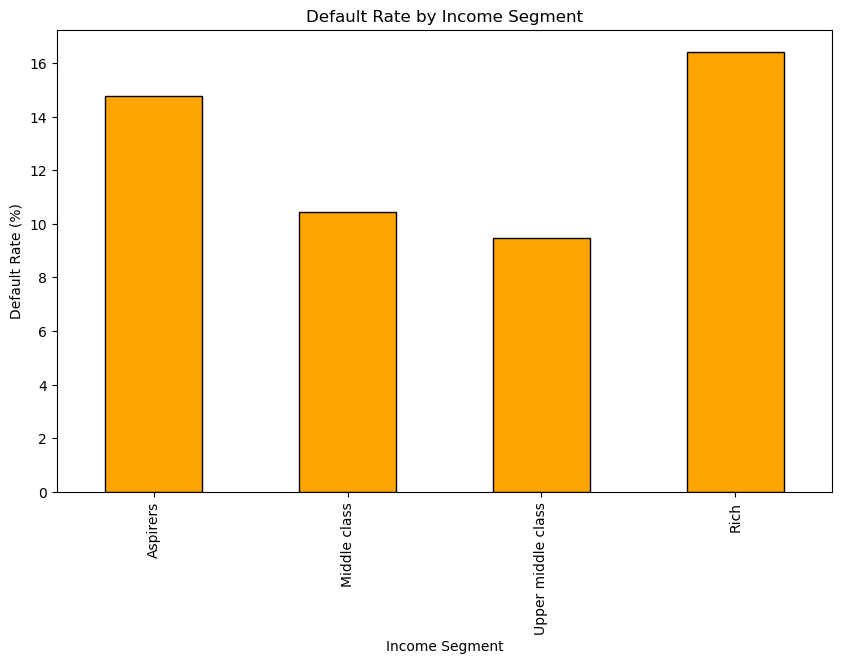

In [192]:
income_bins = [0, 100000, 200000, 500000, loandf['annual_inc'].max()]
income_labels = ['Aspirers', 'Middle class', 'Upper middle class', 'Rich']
loandf['income_segment'] = pd.cut(loandf['annual_inc'], bins=income_bins, labels=income_labels, include_lowest=True)

# Filter defaulters (loan_status == 'Charged Off')
charged_off = loandf[loandf['loan_status'] == 'Charged Off']

# Calculate default rate for each income segment
default_rate_by_income = (charged_off['income_segment'].value_counts() / loandf['income_segment'].value_counts())*100

# Plot the default rate by income segment
plt.figure(figsize=(10, 6))
default_rate_by_income.sort_index().plot(kind='bar', color='orange', edgecolor='black')
plt.title('Default Rate by Income Segment')
plt.xlabel('Income Segment')
plt.ylabel('Default Rate (%)')
plt.show()

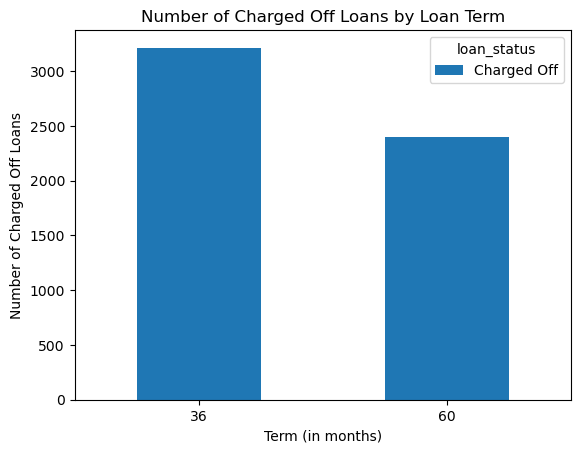

In [200]:
charged_off = loandf[loandf['loan_status'] == 'Charged Off']
charged_off.groupby(['term','loan_status']).size().unstack().plot.bar()
plt.title('Number of Charged Off Loans by Loan Term')
plt.xlabel('Term (in months)')
plt.ylabel('Number of Charged Off Loans')
plt.xticks(rotation=0)
# Show plot
plt.show()

Index(['CA', 'FL', 'NY', 'TX', 'NJ', 'GA', 'IL', 'PA', 'VA', 'MD', 'MA', 'OH',
       'WA', 'AZ', 'NC', 'MO', 'NV', 'MI', 'CO', 'CT', 'MN', 'OR', 'SC', 'WI',
       'LA', 'AL', 'KY', 'OK', 'UT', 'KS', 'NM', 'HI', 'AR', 'NH', 'RI', 'WV',
       'DC', 'AK', 'SD', 'DE', 'MT', 'VT', 'WY', 'NE', 'MS', 'TN', 'ID'],
      dtype='object', name='addr_state')


/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/2484042277.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='addr_state', y='count', data=statewisedefaulters, palette='Blues_d')


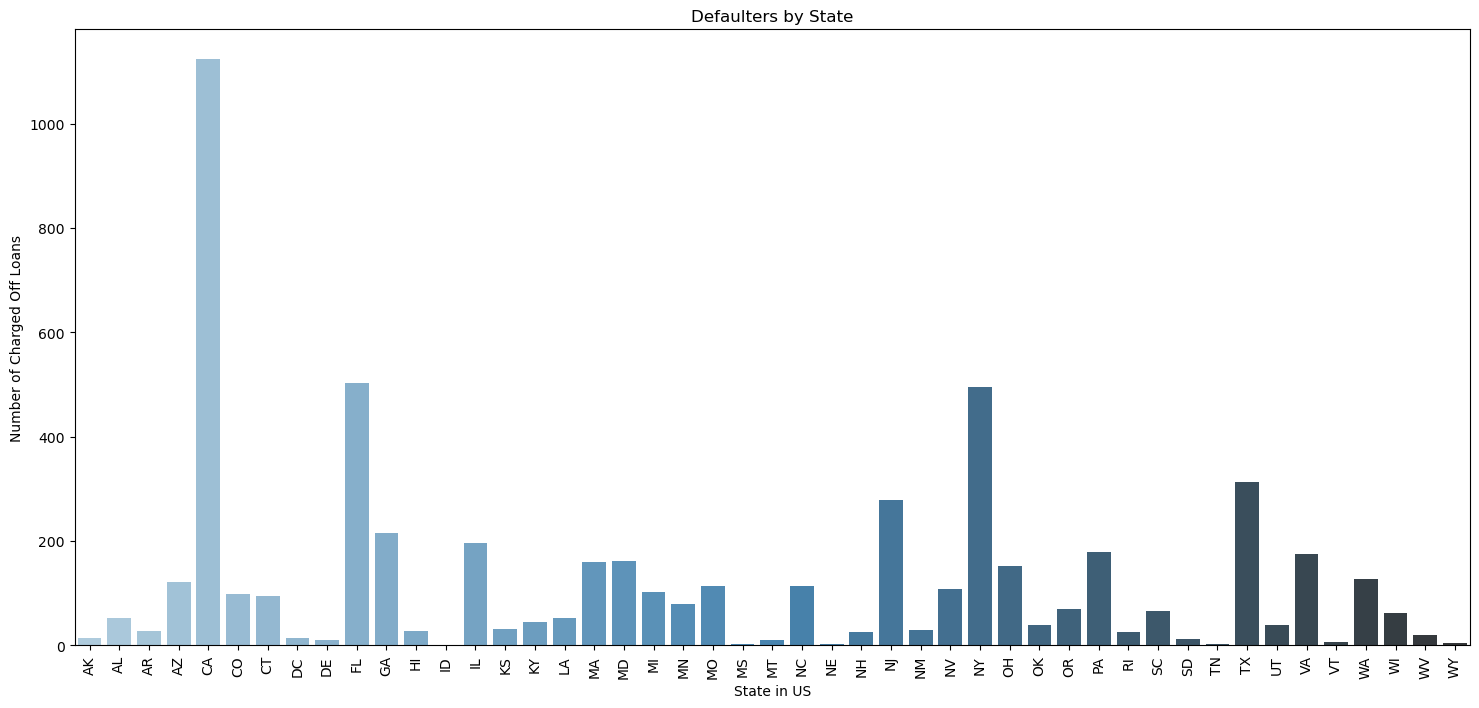

In [218]:
charged_off = loandf[loandf['loan_status'] == 'Charged Off']
print(charged_off['addr_state'].value_counts().index)
plt.figure(figsize=(18, 8))
statewisedefaulters = charged_off.groupby(['addr_state','loan_status']).size().reset_index(name='count')

plt.title('Defaulters by State')
sns.barplot(x='addr_state', y='count', data=statewisedefaulters, palette='Blues_d')
plt.xlabel('State in US')
plt.ylabel('Number of Charged Off Loans')
plt.xticks(rotation=90)
# Show plot
plt.show()

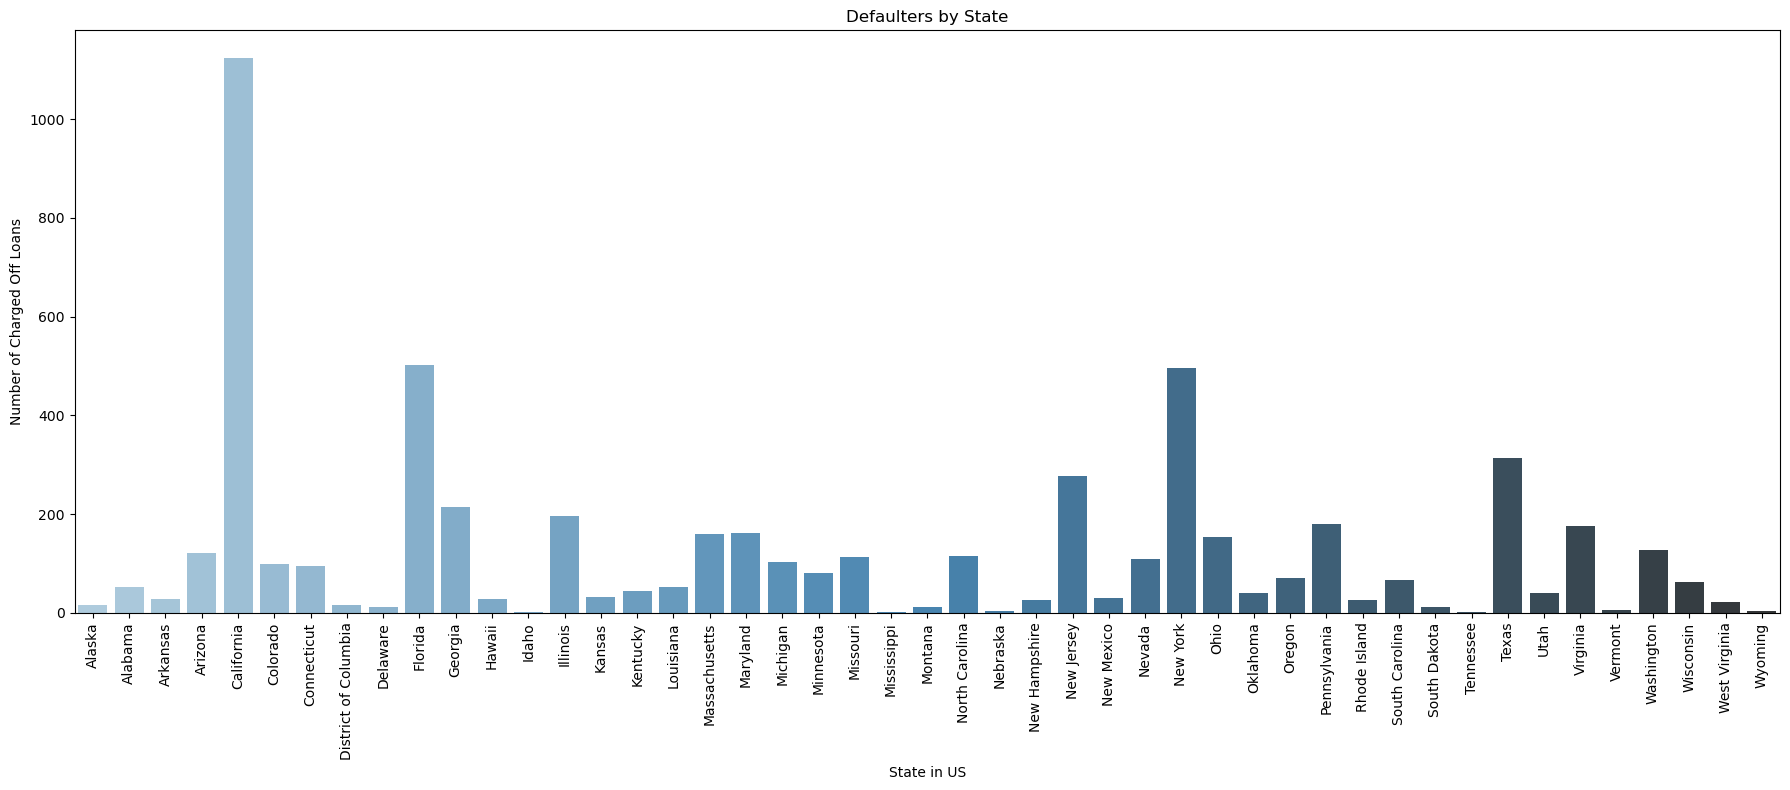

In [220]:
state_name_mapping = {
    'CA': 'California', 'FL': 'Florida', 'NY': 'New York', 'TX': 'Texas', 'NJ': 'New Jersey', 
    'GA': 'Georgia', 'IL': 'Illinois', 'PA': 'Pennsylvania', 'VA': 'Virginia', 'MD': 'Maryland', 
    'MA': 'Massachusetts', 'OH': 'Ohio', 'WA': 'Washington', 'AZ': 'Arizona', 'NC': 'North Carolina',
    'MO': 'Missouri', 'NV': 'Nevada', 'MI': 'Michigan', 'CO': 'Colorado', 'CT': 'Connecticut', 
    'MN': 'Minnesota', 'OR': 'Oregon', 'SC': 'South Carolina', 'WI': 'Wisconsin', 'LA': 'Louisiana',
    'AL': 'Alabama', 'KY': 'Kentucky', 'OK': 'Oklahoma', 'UT': 'Utah', 'KS': 'Kansas', 'NM': 'New Mexico',
    'HI': 'Hawaii', 'AR': 'Arkansas', 'NH': 'New Hampshire', 'RI': 'Rhode Island', 'WV': 'West Virginia',
    'DC': 'District of Columbia', 'AK': 'Alaska', 'SD': 'South Dakota', 'DE': 'Delaware', 'MT': 'Montana',
    'VT': 'Vermont', 'WY': 'Wyoming', 'NE': 'Nebraska', 'MS': 'Mississippi', 'TN': 'Tennessee', 'ID': 'Idaho'
}

# Filter charged off loans
charged_off = loandf[loandf['loan_status'] == 'Charged Off']

# Group by state and get the counts of charged off loans
statewisedefaulters = charged_off.groupby('addr_state').size().reset_index(name='count')

# Add new column for full state names
statewisedefaulters['state_name'] = statewisedefaulters['addr_state'].map(state_name_mapping)

# Plot the data
plt.figure(figsize=(18, 8))
sns.barplot(x='state_name', y='count', data=statewisedefaulters, hue='state_name', palette='Blues_d', legend=False)

# Add title and labels
plt.title('Defaulters by State')
plt.xlabel('State in US')
plt.ylabel('Number of Charged Off Loans')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()

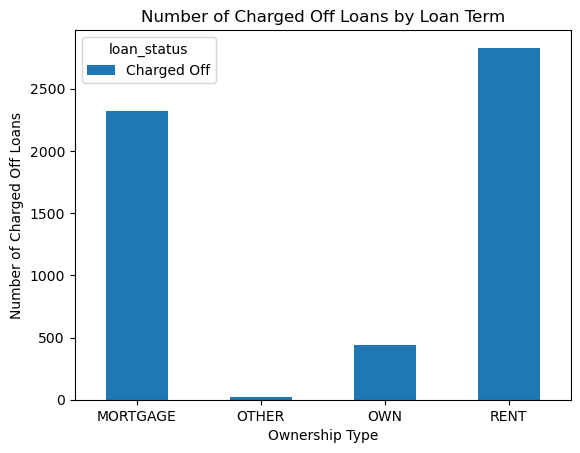

In [222]:
charged_off = loandf[loandf['loan_status'] == 'Charged Off']
charged_off.groupby(['home_ownership','loan_status']).size().unstack().plot.bar()
plt.title('Number of Charged Off Loans by Loan Term')
plt.xlabel('Ownership Type')
plt.ylabel('Number of Charged Off Loans')
plt.xticks(rotation=0)
# Show plot
plt.show()

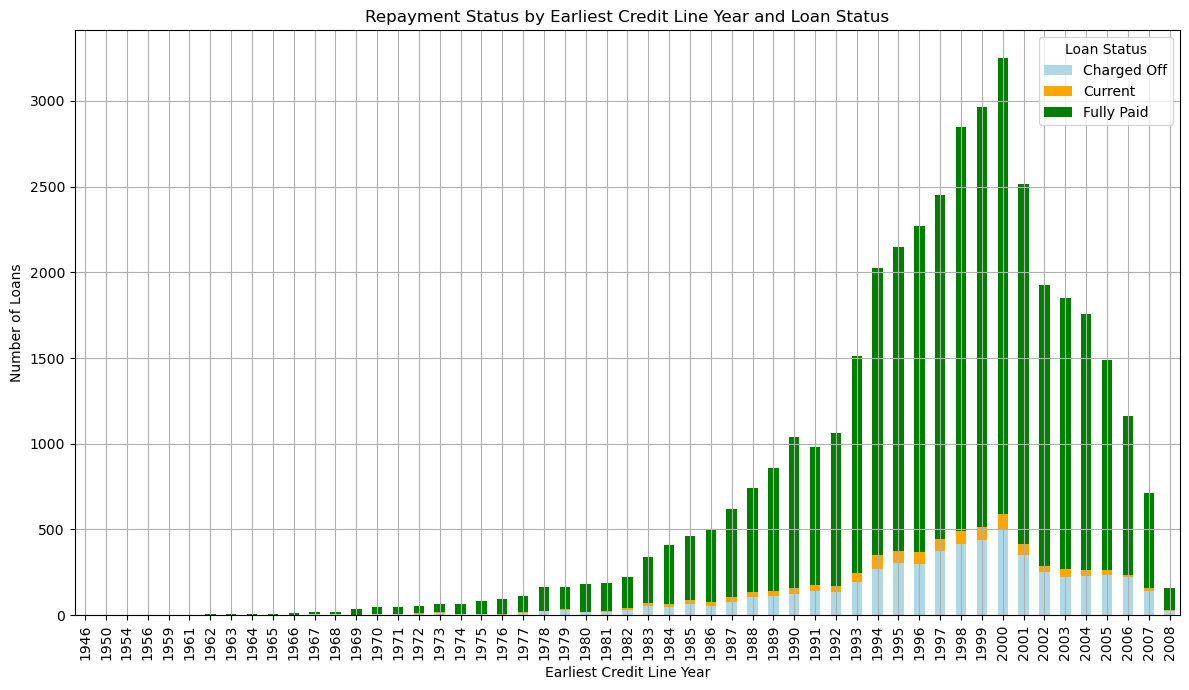

In [226]:
# Create a pivot table to calculate counts of loan status for each combination of year and loan_status
defaulters = loandf[loandf['loan_status'] == 'Charged Off']
filtered_data = defaulters.dropna(subset=['loan_status', 'earliest_cr_line', 'dti'])

# Since earliest_cr_line is already a datetime, extract the year
filtered_data['earliest_cr_line_year'] = filtered_data['earliest_cr_line'].dt.year
repayment_status_pivot = filtered_data.pivot_table(index='earliest_cr_line_year', 
                                                   columns='loan_status', 
                                                   values='dti',  # Use 'dti' or any non-categorical column to aggregate
                                                   aggfunc='count')

# Plot a stacked bar chart of repayment status by earliest credit line year and loan status
repayment_status_pivot.plot(kind='bar', stacked=True, figsize=(12, 7), 
                            color=['lightblue', 'orange', 'green'])  # Adjust colors for loan statuses
plt.title('Repayment Status by Earliest Credit Line Year and Loan Status')
plt.xlabel('Earliest Credit Line Year')
plt.ylabel('Number of Loans')
plt.legend(title='Loan Status')
plt.grid(True)
plt.tight_layout()
plt.show()


    funded_amnt  int_rate  term  total_amount_to_pay  total_pymnt  \
1          2500     15.27    60            4408.7500      1008.71   
8          5600     21.28    60           11558.4000       646.02   
9          5375     12.69    60            8785.4375      1476.19   
12         9000     13.49    36           12642.3000      2270.70   
14        10000     10.65    36           13195.0000      7471.99   

    remaining_amount  
1          3400.0400  
8         10912.3800  
9          7309.2475  
12        10371.6000  
14         5723.0100  


/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/3679236913.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulters['term_months'] = defaulters['term']
/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/3679236913.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  defaulters['monthly_int_rate'] = defaulters['int_rate'] / 12 / 100
/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/3679236913.py:10: SettingWithCopyWarning: 
A value is trying to be set on a c

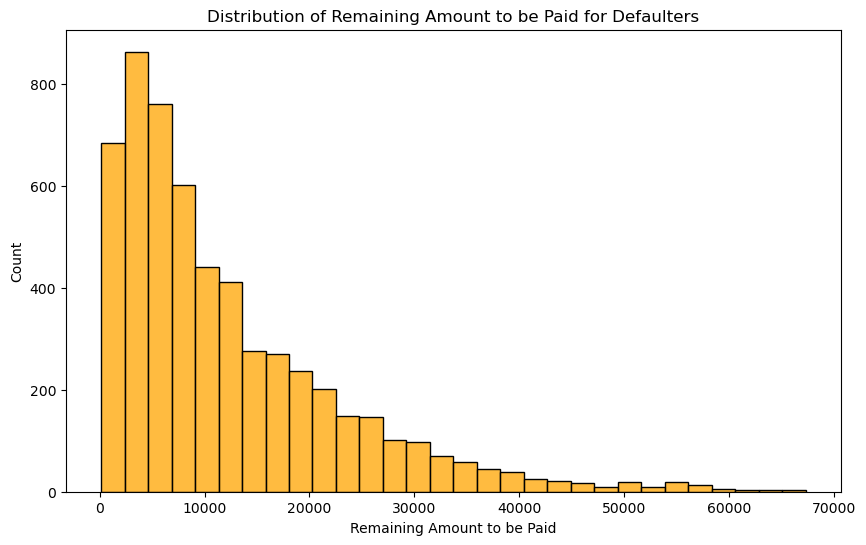

In [281]:
defaulters = loandf[loandf['loan_status'] == 'Charged Off']

# Convert the term to numeric values (36 or 60 months) by removing 'months' and converting to int
defaulters['term_months'] = defaulters['term']

# Calculate the monthly interest rate
defaulters['monthly_int_rate'] = defaulters['int_rate'] / 12 / 100

# Calculate the total interest to be paid over the term (interest * principal * term)
defaulters['total_interest'] = defaulters['funded_amnt'] * defaulters['monthly_int_rate'] * defaulters['term_months']

# Calculate the total amount to be paid (principal + total interest)
defaulters['total_amount_to_pay'] = defaulters['funded_amnt'] + defaulters['total_interest']

# Calculate the remaining amount to be paid (total amount - total payment already made)
defaulters['remaining_amount'] = defaulters['total_amount_to_pay'] - defaulters['total_pymnt']

# Display the columns for checking
print(defaulters[['funded_amnt', 'int_rate', 'term', 'total_amount_to_pay', 'total_pymnt', 'remaining_amount']].head())

# Optional: You can plot the remaining amounts
plt.figure(figsize=(10, 6))
sns.histplot(defaulters['remaining_amount'], kde=False, color='orange', bins=30)
plt.title('Distribution of Remaining Amount to be Paid for Defaulters')
plt.xlabel('Remaining Amount to be Paid')
plt.ylabel('Count')

plt.show()

   issue_date_year  count percentage
0             2007    251      0.60%
1             2008   1562      3.90%
2             2009   4716     11.90%
3             2010  11532     29.00%
4             2011  21656     54.50%


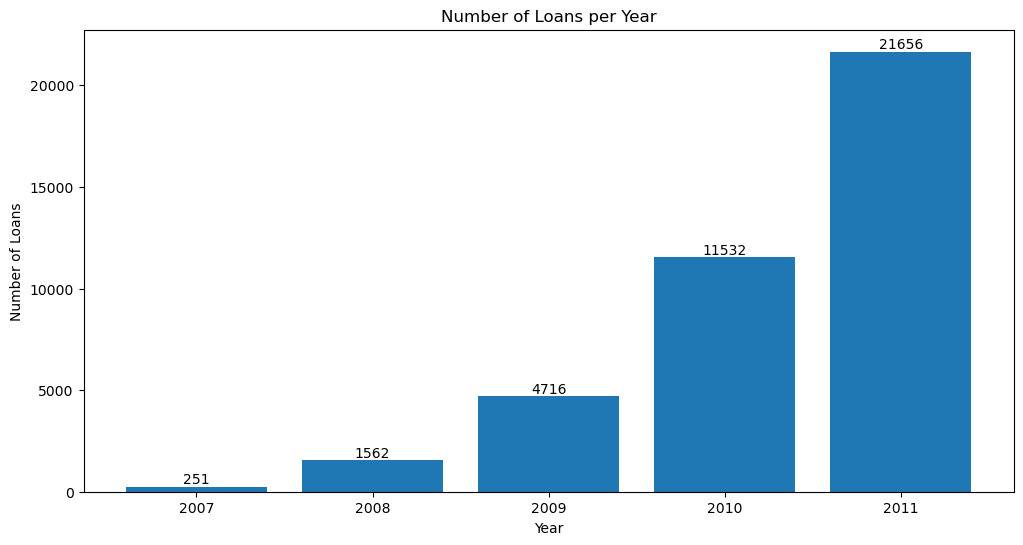

In [274]:
yearly_counts = loandf.groupby('issue_date_year').size().reset_index(name='count')
yearly_counts = yearly_counts.sort_values('issue_date_year')


# Display the result
total_loans = yearly_counts['count'].sum()
yearly_counts['percentage'] = np.round((yearly_counts['count'] / total_loans) * 100, 1)
yearly_counts['percentage'] = yearly_counts['percentage'].apply(lambda x: f'{x:.2f}%')

# Display the result
print(yearly_counts)
plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_counts['issue_date_year'], yearly_counts['count'])
plt.xlabel('Year')
plt.ylabel('Number of Loans')
plt.title('Number of Loans per Year')

# Add YoY growth labels on top of bars
for i, bar in enumerate(bars):
    growth = yearly_counts['count'].iloc[i]
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             growth, ha='center', va='bottom')

plt.show()

Total amount to be repayed 68457203.334569 , amount release is 106895884.64 with loss of 64% for defaulted amount


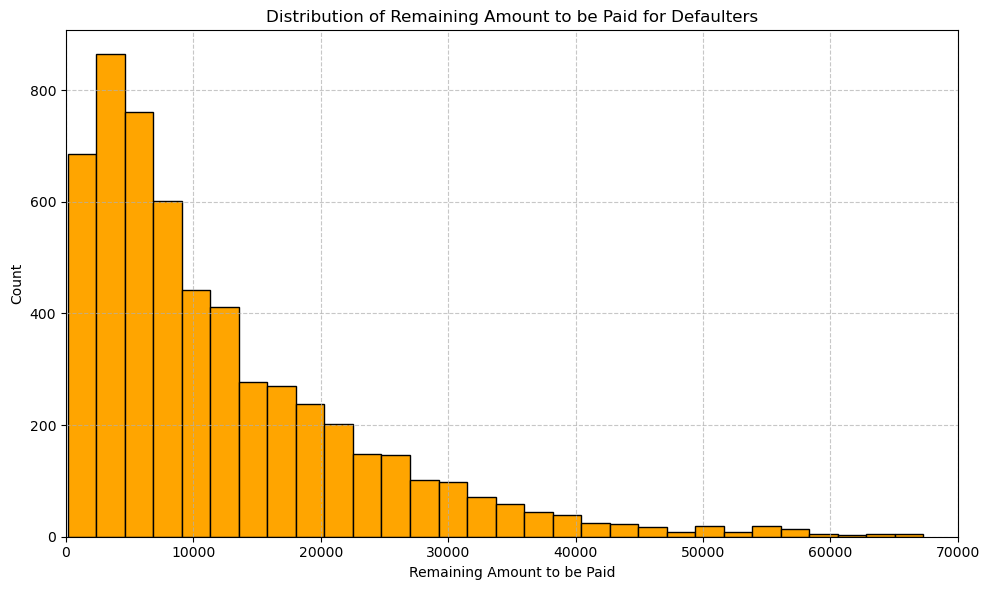

In [293]:
# Filter defaulters and perform calculations in one step
defaulters = loandf[loandf['loan_status'] == 'Charged Off'].assign(
    term_months=lambda x: pd.to_numeric(x['term']),
    monthly_int_rate=lambda x: x['int_rate'] / 12 / 100,
    total_interest=lambda x: x['funded_amnt'] * x['int_rate'] / 12 / 100 * x['term_months'],
    total_amount_to_pay=lambda x: x['funded_amnt'] + x['funded_amnt'] * x['int_rate'] / 12 / 100 * x['term_months'],
    remaining_amount=lambda x: x['funded_amnt'] + x['funded_amnt'] * x['int_rate'] / 12 / 100 * x['term_months'] - x['total_pymnt']
)
remaining_amt = defaulters["remaining_amount"].sum()
released_amt = defaulters['total_amount_to_pay'].sum()
print(f"Total amount to be repayed {remaining_amt} , amount release is {released_amt} with loss of {round((remaining_amt/released_amt)*100)}% for defaulted amount")
# Create the plot
plt.figure(figsize=(10, 6))
plt.hist(defaulters['remaining_amount'], bins=30, color='orange', edgecolor='black')

plt.title('Distribution of Remaining Amount to be Paid for Defaulters')
plt.xlabel('Remaining Amount to be Paid')
plt.ylabel('Count')
plt.xlim(0, 70000)

# Set y-axis limits to start from 0
plt.ylim(0)

plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



Percentage of loans with old credit line and DTI < 36%: 62.66%


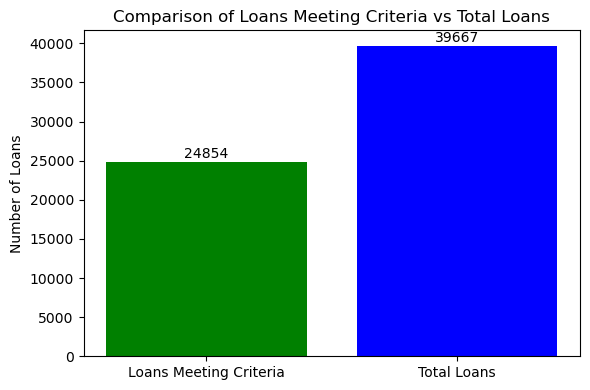

In [303]:
old_threshold = 2000

# Filter loans with earliest_cr_line_year before the threshold and dti less than 36%
filtered_loans = loandf[(loandf['earliest_cr_line_year'] < old_threshold) & (loandf['dti'] < 36)]

# Calculate the total number of loans
total_loans = len(loandf)

# Calculate the number of loans that meet the criteria
loans_meeting_criteria = len(filtered_loans)

# Calculate the percentage of loans that meet the criteria
percentage = (loans_meeting_criteria / total_loans) * 100

# Print the result
print(f"Percentage of loans with old credit line and DTI < 36%: {percentage:.2f}%")

# Create a bar plot to visualize the result
plt.figure(figsize=(6, 4))

# Data for the bar plot
categories = ['Loans Meeting Criteria', 'Total Loans']
values = [loans_meeting_criteria, total_loans]

# Create the bar plot
plt.bar(categories, values, color=['green', 'blue'])

# Add labels and title
plt.title('Comparison of Loans Meeting Criteria vs Total Loans')
plt.ylabel('Number of Loans')

# Annotate the bars with the values
for i, value in enumerate(values):
    plt.text(i, value + 100, f'{value}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

/var/folders/l1/d49970js2337rt253d5bpcpc0000gn/T/ipykernel_67619/1665916251.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='loan_amnt', y='loan_status', data=loandf, palette='coolwarm')


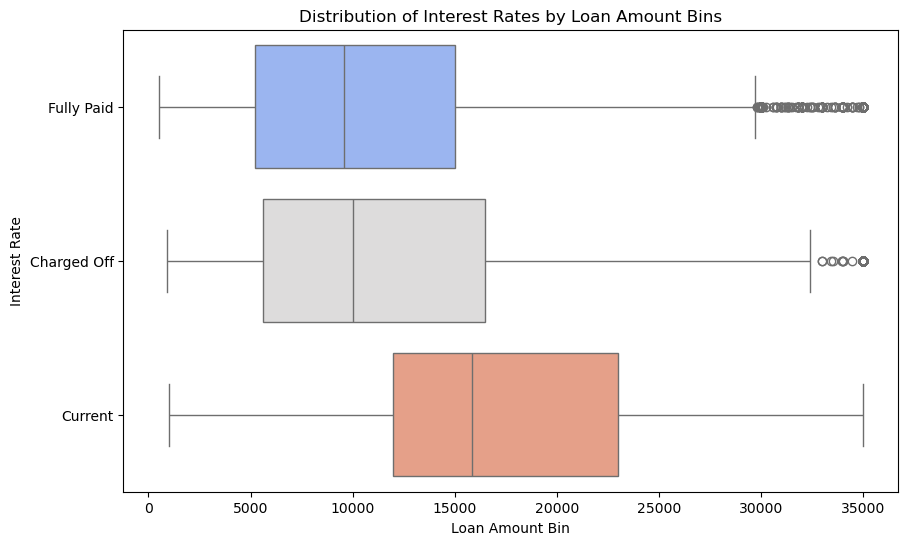

In [300]:
# Define loan amount bins
loan_amnt_bins = [0, 5000, 10000, 15000, 20000, 25000, 35000]
loan_amnt_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High', 'Super High']

# Create a new column for loan amount bins
loandf['loan_amnt_bin'] = pd.cut(loandf['loan_amnt'], bins=loan_amnt_bins, labels=loan_amnt_labels, include_lowest=True)

# Box plot for interest rate distribution across loan amount bins
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_amnt', y='loan_status', data=loandf, palette='coolwarm')
plt.title('Distribution of Interest Rates by Loan Amount Bins')
plt.xlabel('Loan Amount Bin')
plt.ylabel('Interest Rate')
plt.show()

Percentage of loans with old credit line and DTI < 36%: 60.97%


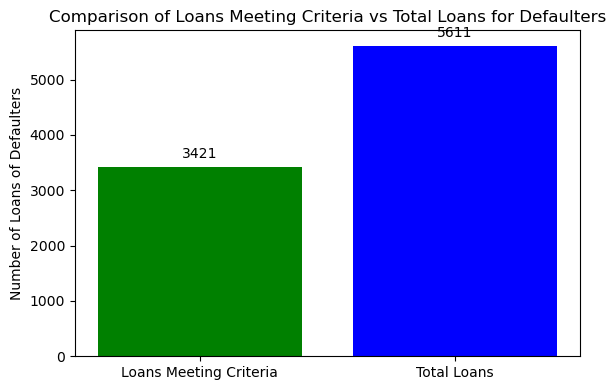

In [306]:
old_threshold = 2000

# Filter loans with earliest_cr_line_year before the threshold and dti less than 36%
filtered_loans = defaulters[(defaulters['earliest_cr_line_year'] < old_threshold) & (defaulters['dti'] < 36)]

# Calculate the total number of loans
total_loans = len(defaulters)

# Calculate the number of loans that meet the criteria
loans_meeting_criteria = len(filtered_loans)

# Calculate the percentage of loans that meet the criteria
percentage = (loans_meeting_criteria / total_loans) * 100

# Print the result
print(f"Percentage of loans with old credit line and DTI < 36%: {percentage:.2f}%")

# Create a bar plot to visualize the result
plt.figure(figsize=(6, 4))

# Data for the bar plot
categories = ['Loans Meeting Criteria', 'Total Loans']
values = [loans_meeting_criteria, total_loans]

# Create the bar plot
plt.bar(categories, values, color=['green', 'blue'])

# Add labels and title
plt.title('Comparison of Loans Meeting Criteria vs Total Loans for Defaulters')
plt.ylabel('Number of Loans of Defaulters')

# Annotate the bars with the values
for i, value in enumerate(values):
    plt.text(i, value + 100, f'{value}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Factors to consider for the giving loan
1. revol_util : Lower the rate better is the score for lending loadn
2. earliest_cr_line: Higher the beeter for lending loan
3. dti: Debt-to-Income: lower the better

loandf